In [12]:
import pandas as pd
import numpy as np
import optuna
import pickle
import sys
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Optuna Logging
optuna.logging.set_verbosity(optuna.logging.INFO)

In [13]:
df=pd.read_csv("innings_1.csv")
matches=pd.read_csv("matches.csv")

if 'id' in matches.columns:
    right_col = 'id'
else:
    right_col = 'match_id'

df = df.merge(matches[[right_col, 'venue']], left_on='match_id', right_on=right_col)
# Rename venue to city for consistency
df.rename(columns={'venue': 'city'}, inplace=True)
df['city'] = df['city'].fillna('Unknown')

# --- Pune Name Fix ---
df['batting_team'] = df['batting_team'].str.replace('Rising Pune Supergiants', 'Rising Pune Supergiant')
df['bowling_team'] = df['bowling_team'].str.replace('Rising Pune Supergiants', 'Rising Pune Supergiant')

print("✅ Data Loaded.")

C:\Users\lenovo\AppData\Local\Temp\ipykernel_21376\1696455499.py:1: DtypeWarning: Columns (28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("innings_1.csv")


✅ Data Loaded.


In [14]:
print("Engineering Features...")

# 1. Calculate TOTAL SCORE for each match
total_scores = df.groupby('match_id')['runs_total'].sum().reset_index()
total_scores.rename(columns={'runs_total': 'final_total_runs'}, inplace=True)
df = df.merge(total_scores, on='match_id')

# 2. Current Situation
df['current_score'] = df.groupby('match_id')['runs_total'].cumsum()
df['wickets_fallen'] = df.groupby('match_id')['is_wicket'].cumsum()
df['wickets_left'] = 10 - df['wickets_fallen']

# 3. Balls & Overs
df['balls_bowled'] = (df['over']*6) + df['ball']
df['balls_left'] = 120 - df['balls_bowled']

# 4. Current Run Rate (CRR)
df['crr'] = (df['current_score']*6) / df['balls_bowled']
df['crr'] = df['crr'].fillna(0)

# 5. Last 5 Overs Runs 
print("✅ Features Created (Target: 'final_total_runs').")

Engineering Features...
✅ Features Created (Target: 'final_total_runs').


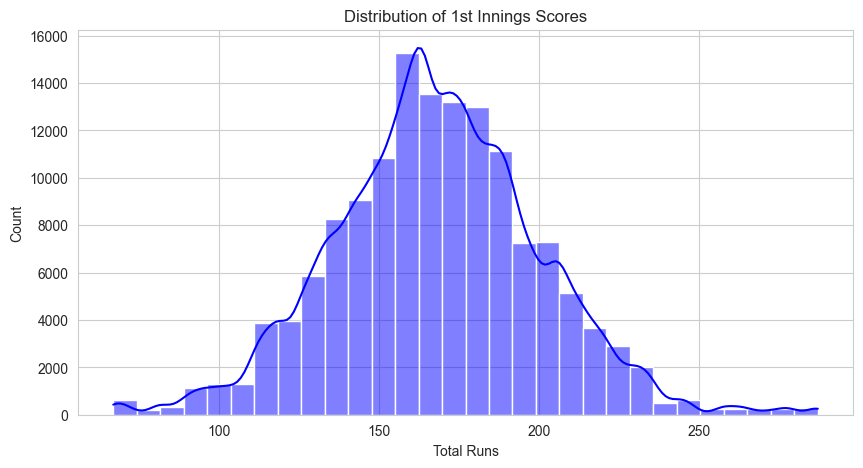

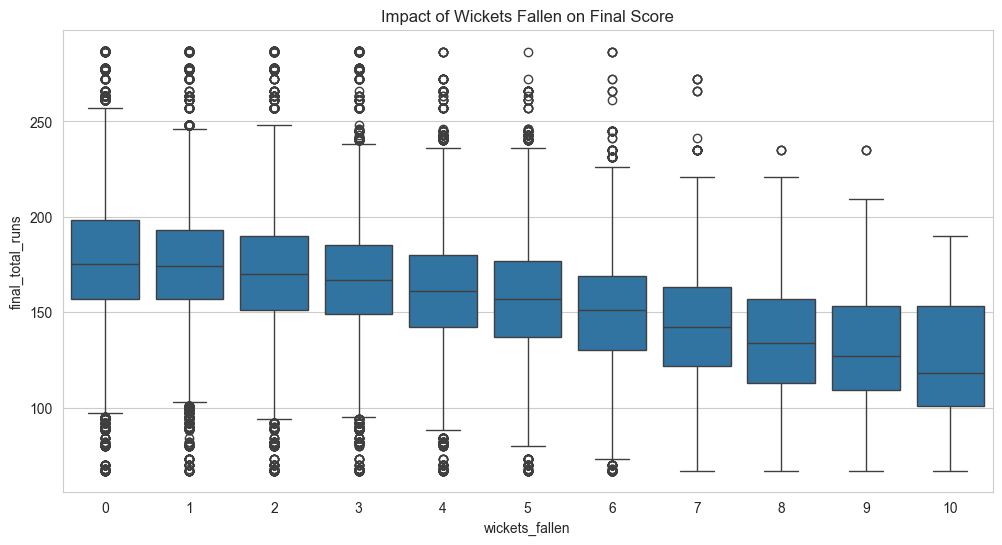

C:\Users\lenovo\AppData\Local\Temp\ipykernel_21376\840132568.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.index, y=top_cities.values, palette='coolwarm')


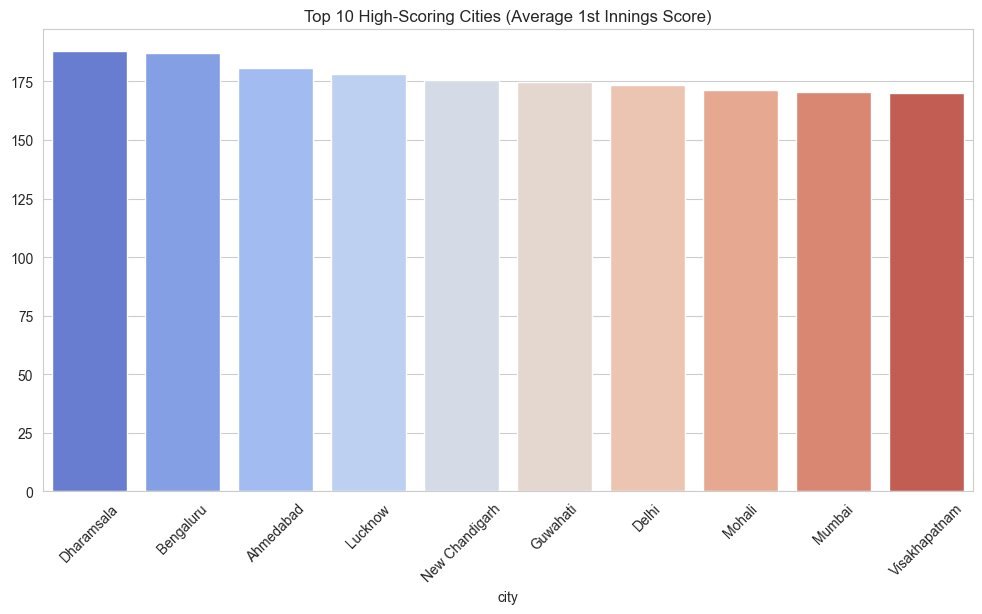

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visuals style
sns.set_style('whitegrid')

# 1. Distribution of Final Scores
plt.figure(figsize=(10, 5))
sns.histplot(df['final_total_runs'], kde=True, bins=30, color='blue')
plt.title('Distribution of 1st Innings Scores')
plt.xlabel('Total Runs')
plt.show()

# 2. Wickets vs Final Score (Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='wickets_fallen', y='final_total_runs', data=df)
plt.title('Impact of Wickets Fallen on Final Score')
plt.show()

# 3. Average Runs by Venue (Top 10)
top_cities = df.groupby('city')['final_total_runs'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.index, y=top_cities.values, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Top 10 High-Scoring Cities (Average 1st Innings Score)')
plt.show()

In [16]:
# Features Selection
features = ['batting_team', 'bowling_team', 'city', 'current_score', 'balls_left', 'wickets_left', 'crr']
X = df[features]
y = df['final_total_runs'] # Regression Target

# Split by Match ID (Important: Don't split ball-by-ball, split match-by-match)
match_ids = df['match_id'].unique()

# Step 1: Divide into (Train + Val) and Test (80% vs 20%)
train_val_match_ids, test_match_ids = train_test_split(match_ids, test_size=0.2, random_state=42)

# Step 2: Divide (Train + Val) into Train and Val (75% of 80% is 60% total, so 25% split here)
train_match_ids, val_match_ids = train_test_split(train_val_match_ids, test_size=0.25, random_state=42)

# Create Datasets
X_train = X[df['match_id'].isin(train_match_ids)]
y_train = y[df['match_id'].isin(train_match_ids)]

X_val = X[df['match_id'].isin(val_match_ids)]
y_val = y[df['match_id'].isin(val_match_ids)]

X_test = X[df['match_id'].isin(test_match_ids)]
y_test = y[df['match_id'].isin(test_match_ids)]

print(f"✅ Data Split Done!")
print(f"Train Rows: {len(X_train)} (Model Learning)")
print(f"Val Rows:   {len(X_val)} (Optuna Tuning)")
print(f"Test Rows:  {len(X_test)} (Final Exam)")

✅ Data Split Done!
Train Rows: 85740 (Model Learning)
Val Rows:   28738 (Optuna Tuning)
Test Rows:  28881 (Final Exam)


In [17]:
cat_cols = ['batting_team', 'bowling_team', 'city']
num_cols = ['current_score', 'balls_left', 'wickets_left', 'crr']

trf = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), cat_cols),
    ('scale', StandardScaler(), num_cols)
])

def objective(trial):
    regressor_name = trial.suggest_categorical('regressor', ['RandomForest', 'XGBoost'])
    
    if regressor_name == 'RandomForest':
        rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)
        rf_max_depth = trial.suggest_int('rf_max_depth', 5, 20)
        rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 10)
        
        model = RandomForestRegressor(
            n_estimators=rf_n_estimators, max_depth=rf_max_depth, 
            min_samples_split=rf_min_samples_split, random_state=42, n_jobs=-1
        )
        
    else:
        xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 200)
        xgb_max_depth = trial.suggest_int('xgb_max_depth', 3, 10)
        xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.3)
        
        model = XGBRegressor(
            n_estimators=xgb_n_estimators, 
            max_depth=xgb_max_depth, 
            learning_rate=xgb_learning_rate, 
            random_state=42, 
            device='cuda', tree_method='hist'
        )

    pipeline = Pipeline([('preprocessor', trf), ('regressor', model)])
    
    # Train on TRAIN set
    pipeline.fit(X_train, y_train)
    
    # Evaluate on VAL set (Not Test!)
    y_pred_val = pipeline.predict(X_val)
    
    return r2_score(y_val, y_pred_val)

print("✅ Objective Function Ready!")

✅ Objective Function Ready!


In [18]:
print("🚀 Starting Optuna Study (Score Predictor)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("\n" + "="*50)
print(f"🏆 Best Model: {study.best_params['regressor']}")
print(f"🎯 Best R2 Score: {study.best_value:.4f}")
print("="*50)

[I 2026-01-09 00:24:02,806] A new study created in memory with name: no-name-affcf955-aac9-499d-a700-f645ac71b063


🚀 Starting Optuna Study (Score Predictor)...


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2026-01-09 00:24:09,444] Trial 0 finished with value: 0.5574077798770085 and parameters: {'regressor': 'RandomForest', 'rf_n_estimators': 161, 'rf_max_depth': 11, 'rf_min_samples_split': 4}. Best is trial 0 with value: 0.5574077798770085.
c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2026-01-09 00:24:16,792] Trial 1 finished with value: 0.5537029692101851 and parameters: {'regressor': 'RandomForest', 'rf_n_estimators': 173, 'rf_max_depth': 12, 'rf_min_samples_split': 8}. Best is trial 0 with value: 0.5574077798770085.
c:\Users\lenovo\MLops Project\.venv\lib\site


🏆 Best Model: XGBoost
🎯 Best R2 Score: 0.5662


In [19]:
print("💾 Saving 1st Innings Score Model...")
best_params = study.best_params

# Re-create the best model
if best_params['regressor'] == 'RandomForest':
    model = RandomForestRegressor(
        n_estimators=best_params['rf_n_estimators'], 
        max_depth=best_params['rf_max_depth'], 
        min_samples_split=best_params['rf_min_samples_split'], 
        random_state=42, n_jobs=-1
    )
else:
    model = XGBRegressor(
        n_estimators=best_params['xgb_n_estimators'], 
        max_depth=best_params['xgb_max_depth'], 
        learning_rate=best_params['xgb_learning_rate'], 
        random_state=42, 
        device='cpu', 
        tree_method='hist',
        n_jobs=-1
    )

final_pipeline = Pipeline([('preprocessor', trf), ('regressor', model)])

# Optional: Best practice is to retrain on Train + Val before final testing
# But for now, let's stick to X_train to see pure generalization
final_pipeline.fit(X_train, y_train)

pickle.dump(final_pipeline, open('pipe_1st_innings.pkl', 'wb'))
print("✅ DONE! Saved as 'pipe_1st_innings.pkl'")

# --- Metrics Analysis ---
print("\n📊 Model Evaluation:")

# 1. Validation Score (Used for tuning)
y_pred_val = final_pipeline.predict(X_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# 2. Test Score (Unseen Data)
y_pred_test = final_pipeline.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"🔹 Validation MAE: {mae_val:.2f} Runs | R2: {r2_val:.4f}")
print(f"🔹 Test MAE:       {mae_test:.2f} Runs | R2: {r2_test:.4f}")

if mae_test > mae_val + 5:
    print("⚠️  Warning: Model might be overfitting (Test error is significantly higher than Val).")
else:
    print("✅  Model is generalizing well.")

💾 Saving 1st Innings Score Model...
✅ DONE! Saved as 'pipe_1st_innings.pkl'

📊 Model Evaluation:
🔹 Validation MAE: 15.92 Runs | R2: 0.5662
🔹 Test MAE:       16.23 Runs | R2: 0.5339
✅  Model is generalizing well.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C:\Users\lenovo\AppData\Local\Temp\ipykernel_21376\1513288598.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


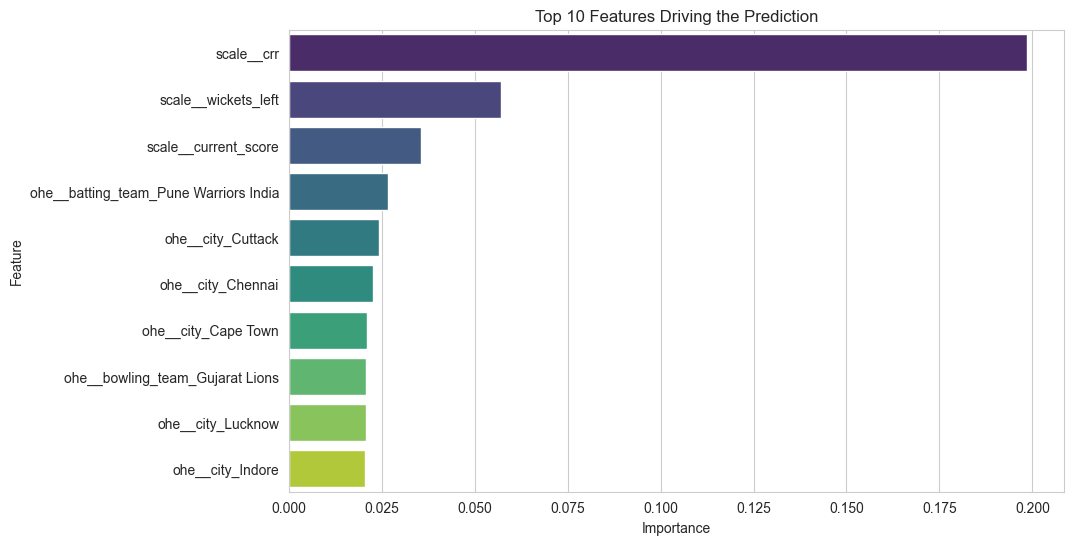

In [20]:
# --- Feature Importance Plot ---
# Extract the model from the pipeline
regressor = final_pipeline.named_steps['regressor']
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = regressor.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Top 10 Features Driving the Prediction')
plt.show()

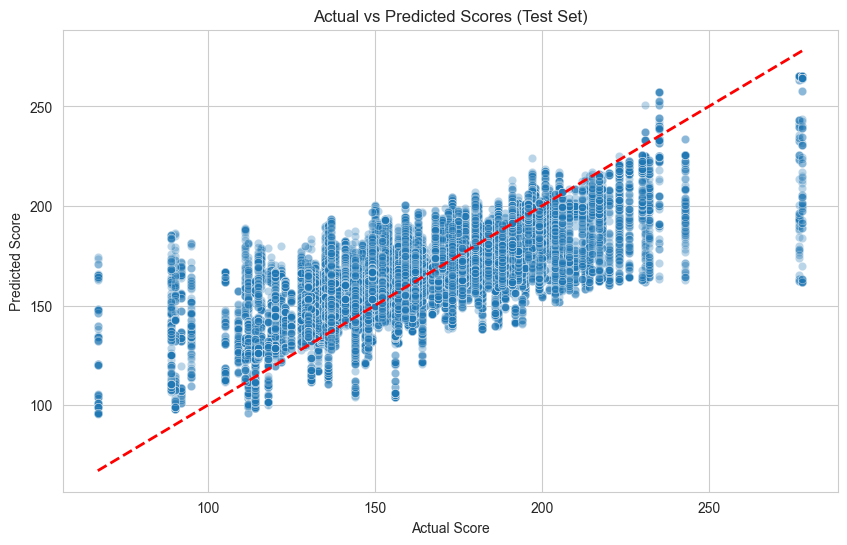

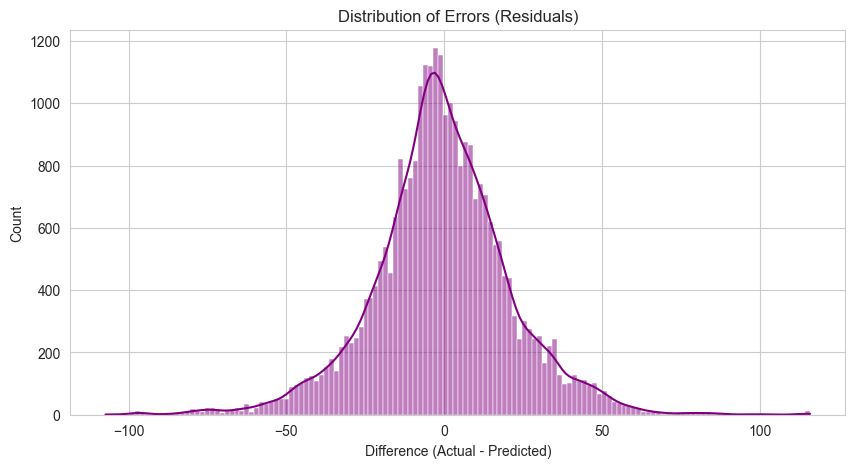

In [21]:
# --- Prediction Error Plot ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, linestyle='--')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Actual vs Predicted Scores (Test Set)')
plt.show()

# --- Residual Plot (Errors) ---
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Distribution of Errors (Residuals)')
plt.xlabel('Difference (Actual - Predicted)')
plt.show()